In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn = C_syn
        self.bias = bias
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1, bias=self.bias))
        
        
    def forward(self, S, temp, test):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        W_clust = self.C_syn
        
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        ####
        raw_out = torch.zeros(T_data, self.sub_no*self.H_no).to(self.device)
        ###
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
            
            ####
            raw_out[:,s*self.H_no:(s+1)*self.H_no] = raw_out[:,s*self.H_no:(s+1)*self.H_no] + rnn_out.squeeze(0)
            #####
        
        final = torch.sum(sub_out, 1)
        
        #return final, sub_out, W_clust
        return final, raw_out, W_clust

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 4
layer_no = 1
sub_no = 4
#in_no = e_idx.shape[0] + i_idx.shape[0]
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

bias = False

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:

C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1


#C_syn = torch.zeros(sub_no, in_no).to(device)
#for s in range(sub_no):
    #C_syn[s,s*in_no//sub_no:(s+1)*in_no//sub_no] = 1

In [7]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, C_syn, bias, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.7)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

651


In [8]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0
#print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        #print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    #V_pred, _, __ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp, False)
    V_pred, _, __ = model(batch_E_neural[:,e_idx], temp, False)
    #V_pred, _, __ = model(batch_E_neural[:,880:1120], temp, False)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_W_clust = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp, True)
        test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)
        #test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,880:1120], temp, True)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        clust_loss = torch.mean(torch.abs(test_W_clust[:,1:] - test_W_clust[:,:-1])).item()
        
        print(i, np.round(test_score,6),
              np.round(test_mse,6),
              np.round(train_score,6),
              np.round(loss.item(),6),
              np.round(clust_loss,6))


<ipython-input-8-f07ffb9291cd>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.028232 0.103912 -0.043524 0.136825 0.072148
49 0.017651 0.027001 0.016981 0.037984 0.072148
99 0.076391 0.02536 0.095115 0.025542 0.072148
149 0.186399 0.022388 0.234994 0.019402 0.072148
199 0.210255 0.021681 0.208876 0.021529 0.072148
249 0.213634 0.021621 0.253579 0.02388 0.072148
299 0.22015 0.021441 0.256714 0.02492 0.072148
349 0.224189 0.021298 0.190062 0.019825 0.072148
399 0.227246 0.021239 0.282007 0.019229 0.072148
449 0.231479 0.021205 0.255538 0.023601 0.072148
499 0.234994 0.021085 0.339526 0.015932 0.072148
549 0.23543 0.02099 0.245324 0.02277 0.072148
599 0.236665 0.02107 0.254445 0.022428 0.072148
649 0.23874 0.020909 0.276639 0.017123 0.072148
699 0.238344 0.020909 0.300051 0.02566 0.072148
749 0.243839 0.020758 0.266366 0.019796 0.072148
799 0.242743 0.020947 0.223868 0.023922 0.072148
849 0.244723 0.020814 0.265551 0.021587 0.072148
899 0.244329 0.020745 0.235324 0.02442 0.072148
949 0.245937 0.020708 0.256936 0.02463 0.072148
999 0.248706 0.020635 0.295734 0.0

8299 0.441497 0.015344 0.492215 0.017816 0.072148
8349 0.45086 0.015077 0.471343 0.014561 0.072148
8399 0.453674 0.014998 0.444915 0.01766 0.072148
8449 0.411348 0.016174 0.538008 0.010098 0.072148
8499 0.406169 0.016303 0.451762 0.018416 0.072148
8549 0.420572 0.015942 0.525809 0.013708 0.072148
8599 0.411385 0.016163 0.360219 0.015372 0.072148
8649 0.435132 0.015524 0.462604 0.017873 0.072148
8699 0.439113 0.015398 0.453481 0.013888 0.072148
8749 0.418064 0.016001 0.475571 0.018963 0.072148
8799 0.374691 0.017181 0.52662 0.011622 0.072148
8849 0.425641 0.015779 0.411791 0.018129 0.072148
8899 0.441101 0.015383 0.506616 0.01439 0.072148
8949 0.43979 0.015392 0.4503 0.016365 0.072148
8999 0.348633 0.01791 0.479442 0.013063 0.072148
9049 0.428463 0.015886 0.453945 0.01626 0.072148
9099 0.4177 0.016018 0.463296 0.015859 0.072148
9149 0.460639 0.014807 0.543436 0.012078 0.072148
9199 0.447478 0.015174 0.500235 0.014796 0.072148
9249 0.447311 0.015199 0.402631 0.013689 0.072148
9299 0.4304

KeyboardInterrupt: 

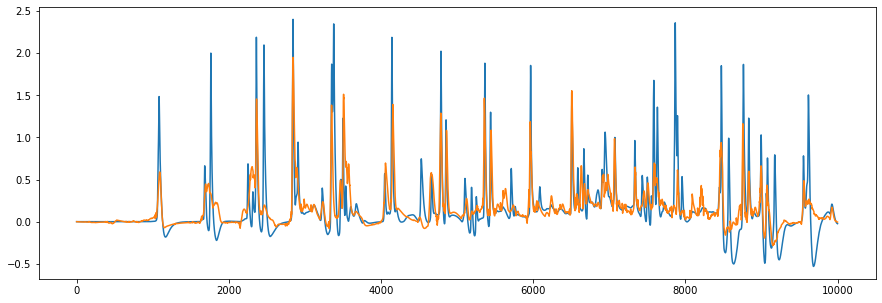

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

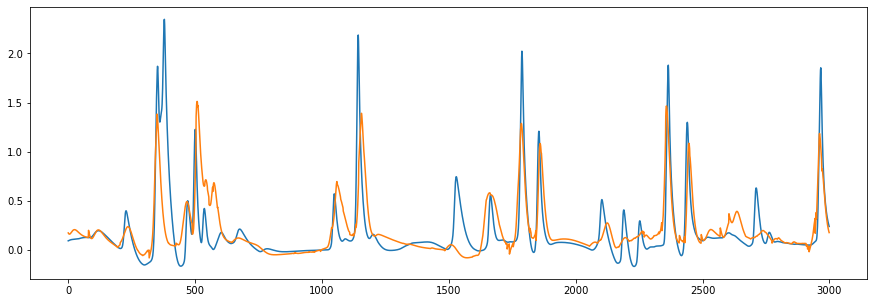

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

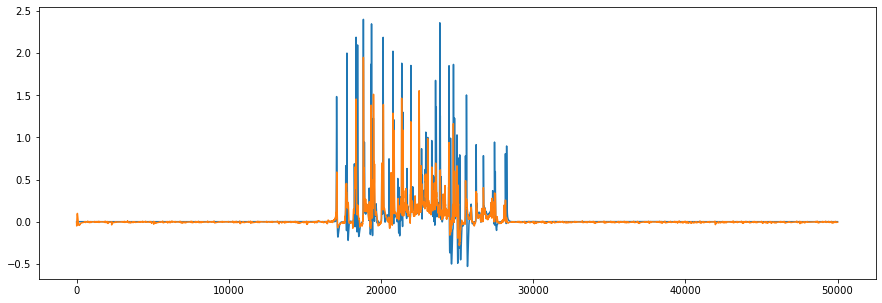

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

In [12]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

In [13]:
sub_neural = torch.matmul(test_E_neural[:,e_idx],C_syn.T)
sub_neural = sub_neural.cpu().detach().numpy()
print(sub_neural.shape)

(50000, 4)


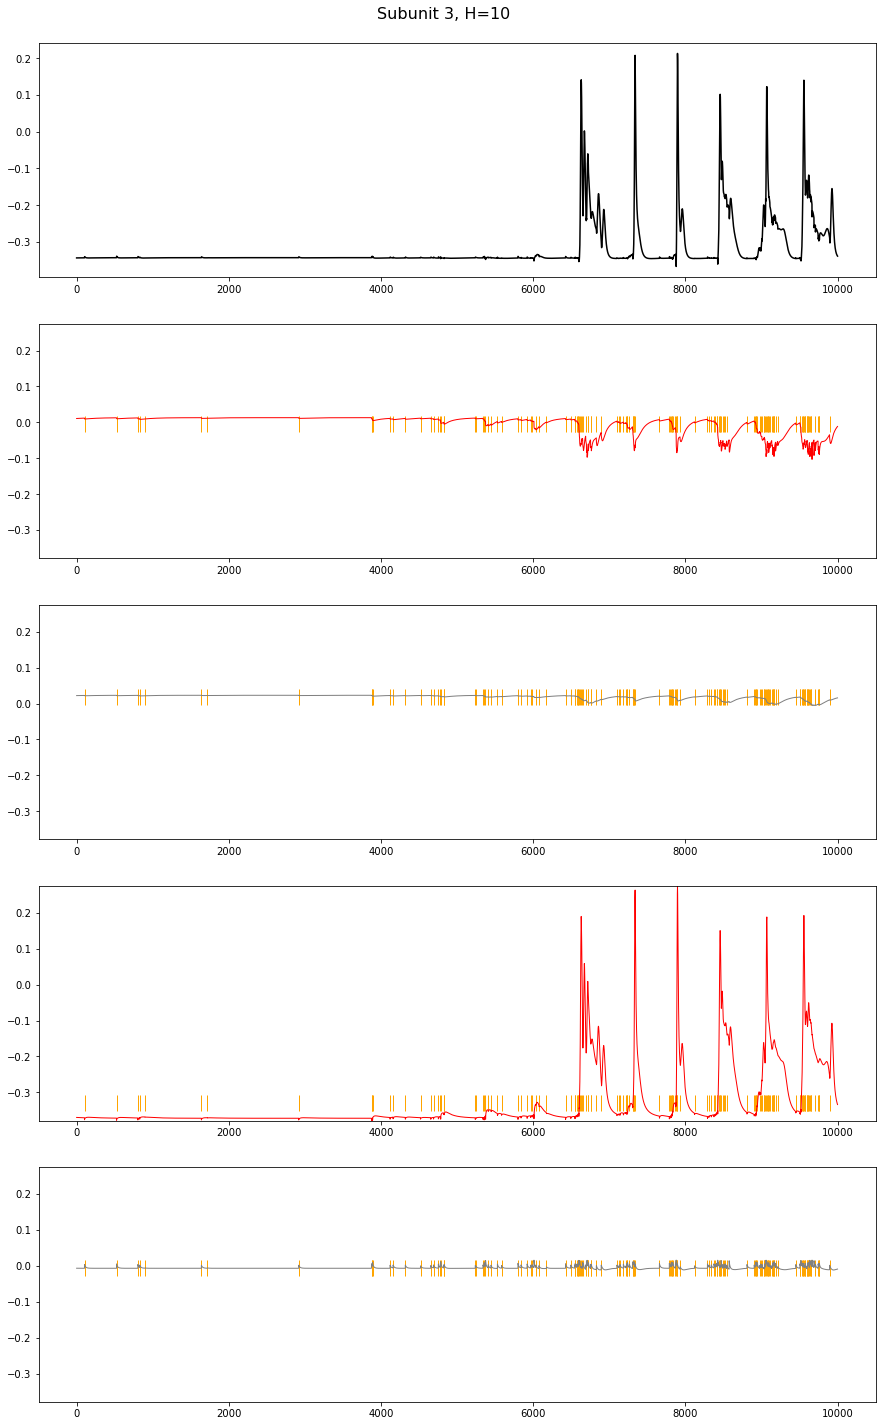

In [19]:
fig, axs = plt.subplots(nrows=H_no+1, figsize = (15,25))

sub = 3

W = model.linear[sub].weight.cpu().detach().numpy().flatten()

total = np.zeros((10000))

min_val = np.min(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)
max_val = np.max(test_sub_out[:,sub*H_no:(sub+1)*H_no].cpu().detach().numpy()[16000:26000]*W)

for i in range(H_no):
    mean = np.mean(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #min_val = np.min(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    #max_val = np.max(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i])
    
    if W[i] >= 0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="red", linewidth=1)
    elif W[i] <= -0.1:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="blue", linewidth=1)
    else:
        axs[i+1].plot(test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i], color="gray", linewidth=1)
    
    axs[i+1].scatter(np.arange(10000), sub_neural[16000:26000,sub]-1+mean, marker="|", s=250, color="orange", linewidth=1)
    axs[i+1].set_ylim(min_val, max_val)
    total += test_sub_out[:,i+sub*H_no].cpu().detach().numpy()[16000:26000]*W[i]
    
#axs[0].plot(V_test.cpu().detach().numpy()[16000:26000], color="black")
#axs[0].plot(test_V_pred.cpu().detach().numpy()[16000:26000], color="red")
axs[0].plot(total, color="black")
    
fig.suptitle("Subunit "+str(sub)+", H=10", y=0.9, fontsize = 16)
plt.savefig("/media/hdd01/sklee/CA1_clust4-60/gru_s"+str(sub_no)+"_h"+str(H_no)+"_output_"+str(sub)+".png", dpi=150, bbox_inches='tight')

In [59]:
print(model.linear[1].weight)

Parameter containing:
tensor([[ 0.6131, -0.5933,  0.0013, -0.2028,  0.3887,  0.0220, -0.1920, -0.0904,
          0.1831, -0.3493]], device='cuda:0', requires_grad=True)


In [ ]:
final = np.zeros((10000))

for i in range(10):
    final += test_sub_out[:,i].cpu().detach().numpy()[16000:26000]*W[i]